[View in Colaboratory](https://colab.research.google.com/github/sleepless-se/Abstract/blob/master/stock_filter_013.ipynb)

予測が外れている原因を突き止める。

間違って予想した要素をここで予測すると正確な値を返すか。

同じ値を返すのなら学習内容自体に問題がある。

In [0]:

!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

In [2]:
import sys
import MeCab
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras import models
from keras import layers
import time
import numpy as np
from google.colab import files
import re
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
mecab = MeCab.Tagger ("-Owakati")

Using TensorFlow backend.


In [6]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/stock_filter"
!ls base_dir

Mounted at /content/gdrive
stock_label_2018-09-11.csv


In [0]:
files.upload()
!ls

In [38]:
import pandas as pd

file_name = 'stock_label_2018-09-11.csv'
df0 = pd.read_csv("{}/{}".format(base_dir,file_name),sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})

def add_space_front_uppercase(text:str)->str:
  return ''.join(' ' + char if char.isupper() else char.strip() for char in text).strip()

def add_space_color_size(text:str)->str:
  return text.replace("color"," color ").replace("size"," size ")


def tag_filter(tag:str)->str:
  tags = ["option","li","div","span"]
  tag = tag if tag in tags else "0"
  return tag

def wakati(text)->str:
  text = str(text)
  if len(text)>3:
    text = mecab.parse(text)
  return replace_numbers_to_0(text)

def replace_numbers_to_0(text:str)->str:
  return re.sub(r'[0-9]+', "0",str(text))

df0[["iid","style","text"]] = df0[["iid","style","text"]].applymap(lambda x : wakati(x)).fillna("")
df0[["iid","style"]] = df0[["iid","style"]].applymap(lambda x : add_space_front_uppercase(x))
df0[["iid","style"]] = df0[["iid","style"]].applymap(lambda x : add_space_color_size(x))
df0["tag"] = df0[["tag"]].applymap(lambda x : tag_filter(x))


b'Skipping line 59768: expected 11 fields, saw 19\nSkipping line 59976: expected 11 fields, saw 19\nSkipping line 63711: expected 11 fields, saw 19\nSkipping line 63871: expected 11 fields, saw 19\nSkipping line 65181: expected 11 fields, saw 19\nSkipping line 65333: expected 11 fields, saw 19\n'
b'Skipping line 66698: expected 11 fields, saw 19\nSkipping line 66858: expected 11 fields, saw 19\nSkipping line 67760: expected 11 fields, saw 19\nSkipping line 67938: expected 11 fields, saw 19\nSkipping line 81846: expected 11 fields, saw 12\nSkipping line 81847: expected 11 fields, saw 12\n'
b'Skipping line 170916: expected 11 fields, saw 13\nSkipping line 170988: expected 11 fields, saw 13\nSkipping line 171186: expected 11 fields, saw 13\nSkipping line 171228: expected 11 fields, saw 13\nSkipping line 171270: expected 11 fields, saw 13\nSkipping line 171344: expected 11 fields, saw 13\nSkipping line 171348: expected 11 fields, saw 13\nSkipping line 171352: expected 11 fields, saw 13\nSk

ラベルが無い項目を削減

In [39]:
df = df0

# df.shape
lis = df["label"].isnull()
df_null = df[lis]
df_null = df_null[0:90000]
print(df_null.shape)

df = df.drop(df[lis].index)
print(df.shape)

df = df.append(df_null)
print(df.shape)


(90000, 11)
(10127, 11)
(100127, 11)


In [40]:
df[101:103].to_json(orient='records')

'[{"id":"9673","label":"stock","tag":"li","iid":" size 0","style":"js-track-me size  color  size -elmta-itempage_ size 0selected","x":769.0,"y":414.0,"height":44.0,"width":56.0,"page_id":30.0,"text":"0 . 0 US \\n"},{"id":"9998","label":"variat","tag":"li","iid":" color 0 B D","style":" color  size -elmselected","x":781.0,"y":313.0,"height":32.0,"width":32.0,"page_id":31.0,"text":"nan"}]'

In [41]:
X = df
fileds = ["id","tag","iid","style",]
fields = ['x', 'y', 'height', 'width']
X = df[fields]
print(X.columns)
print(X.shape)
# X[X["height"]==32]

Index(['x', 'y', 'height', 'width'], dtype='object')
(100127, 4)


In [0]:
import pickle

def tokanaize(df,filed,num_words = None):
  token = None
  # tokanizer
  if num_words == None:
    token = Tokenizer(lower=True)
  else:
    token = Tokenizer(lower=True,num_words=num_words) 
  token.fit_on_texts(df[filed])
  print(token.word_counts)
  
  import pickle

  # saving
  file_name = '{}/tokenizer_{}.pickle'.format(base_dir,filed)
  with open(file_name, 'wb') as handle:
      pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
  
  # word count   
  words_count = len(token.word_counts) +1
  print("{} words".format(words_count))
  if num_words != None:words_count = num_words
  
  
  columns = ["{}{}".format(filed,i) for i in range(words_count)]
  text_matrix = token.texts_to_matrix(df[filed] ,mode='count')
  df_iid = pd.DataFrame(text_matrix)
  df_iid.columns = columns
  return df_iid

In [43]:
df_tag = tokanaize(df,"tag")
X = X.join(df_tag)
print(X.columns)
print(X.shape)

OrderedDict([('li', 24122), ('option', 6566), ('0', 521), ('span', 45376), ('div', 23542)])
6 words
Index(['x', 'y', 'height', 'width', 'tag0', 'tag1', 'tag2', 'tag3', 'tag4',
       'tag5'],
      dtype='object')
(100127, 10)


In [44]:
df_iid = tokanaize(df,"iid",25)
X = X.join(df_iid)
print(X.columns)
print(X.shape)


OrderedDict([('color', 317), ('0', 1114), ('q', 11), ('e', 224), ('x', 24), ('a', 57), ('u', 19), ('v', 28), ('size', 1187), ('o', 33), ('p', 37), ('j', 24), ('m', 28), ('n', 26), ('f', 250), ('k', 30), ('s', 59), ('w', 20), ('i', 32), ('d', 238), ('b', 20), ('r', 224), ('g', 24), ('t', 16), ('l', 35), ('c', 14), ('h', 20), ('nan', 93974), ('sole', 4), ('other', 4), ('materials', 4), ('decided…', 3), ('see', 3), ('more', 50), ('format', 842), ('composition', 240), ('info', 1446), ('item', 480), ('description', 258), ('measurements', 151), ('shipping', 346), ('share', 240), ('js', 240), ('price', 311), ('cod0', 240), ('label', 65), ('replacer', 65), ('made', 95), ('in', 95), ('wearability', 68), ('bc', 142), ('home', 71), ('product', 688), ('chrome', 73), ('header', 71), ('breadcrumb', 73), ('asos', 2), ('gallery', 142), ('content', 283), ('aside', 211), ('colour', 71), ('guide', 190), ('add', 71), ('save', 71), ('restrictions', 70), ('oos', 70), ('retry', 70), ('details', 106), ('lower

In [45]:
df_style = tokanaize(df,"style",75)
X = X.join(df_style)
print(X.columns)
print(X.shape)
# X[0:10]

OrderedDict([('color', 2090), ('size', 9716), ('elmselected', 240), ('elm', 59), ('js', 818), ('track', 867), ('me', 863), ('elmta', 793), ('itempage', 793), ('0selected', 65), ('0', 5192), ('0slick', 414), ('slideslick', 3043), ('currentslick', 654), ('active', 3122), ('activedisabled', 62), ('0disabled', 38), ('nan', 41187), ('box', 125), ('is', 1046), ('last', 445), ('item', 10663), ('disabledis', 228), ('sold', 256), ('out', 525), ('limited', 347), ('availability', 392), ('disabled', 46), ('h', 143), ('e', 90), ('x', 91), ('number', 433), ('message', 40), ('in', 131), ('stock', 427), ('pure', 1455), ('menu', 1455), ('list', 9495), ('thumbselected', 208), ('thumb', 634), ('margin', 1206), ('0x0', 966), ('top', 1164), ('0x', 485), ('topmargin', 240), ('bottom', 258), ('pull', 4856), ('lefttext', 4862), ('centercol', 4856), ('0js', 4856), ('slider', 4876), ('itemfirstta', 486), ('carousel', 5127), ('item0slick', 4856), ('itemta', 3884), ('slide', 2753), ('itemlastta', 486), ('font', 9

In [46]:
df_style = tokanaize(df,"text",num_words=50)
X = X.join(df_style)
print(X.columns)
print(X.shape)

OrderedDict([('nan', 44430), ('0', 139415), ('fr', 1), ('eu', 7601), ('uk', 13763), ('us', 1040), ('br', 8), ('not', 9483), ('available', 9376), ('w', 19276), ('l', 19357), ('no', 114), ('size', 1634), ('one', 1903), ('in', 25792), ('cm', 11250), ('a', 1347), ('cup', 90), ('b', 152), ('c', 194), ('d', 142), ('dd', 120), ('e', 184), ('xs', 276), ('s', 1027), ('m', 275), ('f', 81), ('ff', 75), ('g', 163), ('0a', 2), ('0e', 1), ('xxs', 45), ('xl', 164), ('wide', 785), ('fit', 1082), ('0b', 2), ('0c', 1), ('0d', 2), ('only', 1695), ('left', 2060), ('申し訳', 19), ('ござい', 19), ('ませ', 19), ('ん', 19), ('。', 133), ('この', 261), ('商品', 488), ('は', 19), ('完売', 23), ('し', 23), ('まし', 23), ('た', 39), ('uk0', 2), ('売り切れ', 5), ('ホーム', 244), ('レディース', 244), ('新着', 3), ('アイテム', 582), ('ジュエリー', 1), ('イヤリング', 8), ('apples', 6), ('figs', 6), ('素材', 436), ('構成', 240), ('シルバー', 16), ('金メッキ', 1), ('バロック', 1), ('真珠', 1), ('キュービックジルコニア', 1), ('説明', 1), ('装飾', 160), ('なし', 144), ('スタッドピアス', 1), ('大き', 1), ('さ', 35

In [0]:
X = X.fillna(0)
# X

In [48]:

y = df["label"].fillna("")

def label_filter(text:str)->str:
  label = ["stock","nostock","variat"]
#   label = ["stock","variat"]
  lis=[]
  if text in label:
    return text
  else:
    return ""

y = list(map(label_filter,y))


label_token = Tokenizer()
label_token.fit_on_texts(y)
label_dic= {v: k for k, v in label_token.word_index.items()}
label_dic[0]=""
print(label_dic)
# y = list(map(lambda y : token.word_index.get(y),y))
y = label_token.texts_to_matrix(y)

{1: 'stock', 2: 'nostock', 3: 'variat', 0: ''}


In [0]:
seed = 7
np.random.seed(seed)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=seed)

In [0]:
def non_shuffling_train_test_split(X, y, test_size=0.33):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test
# X_train, X_test, y_train, y_test  = non_shuffling_train_test_split(X, y, test_size=0.33)

In [51]:
# X_train
X_train.columns

Index(['x', 'y', 'height', 'width', 'tag0', 'tag1', 'tag2', 'tag3', 'tag4',
       'tag5',
       ...
       'text40', 'text41', 'text42', 'text43', 'text44', 'text45', 'text46',
       'text47', 'text48', 'text49'],
      dtype='object', length=160)

In [52]:
print(y_train.shape)
y_train



(67085, 4)


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Train on 67085 samples, validate on 33042 samples
Epoch 1/20
67085/67085 [==============================] - 3s 38us/step - loss: 2.0717 - acc: 0.7740 - val_loss: 0.3076 - val_acc: 0.9403
Epoch 2/20
67085/67085 [==============================] - 2s 34us/step - loss: 0.3133 - acc: 0.9442 - val_loss: 0.2812 - val_acc: 0.9862
Epoch 3/20
67085/67085 [==============================] - 2s 34us/step - loss: 0.2865 - acc: 0.9776 - val_loss: 0.2795 - val_acc: 0.9915
Epoch 4/20
67085/67085 [==============================] - 2s 34us/step - loss: 0.2831 - acc: 0.9795 - val_loss: 0.2782 - val_acc: 0.9916
Epoch 5/20
67085/67085 [==============================] - 2s 34us/step - loss: 0.2816 - acc: 0.9813 - val_loss: 0.2769 - val_acc: 0.9922
Epoch 6/20
67085/67085 [==============================] - 2s 34us/step - loss: 0.2807 - acc: 0.9824 - val_loss: 0.2772 - val_acc: 0.9916
Epoch 7/20
67085/67085 [==============================] - 2s 34us/step - loss: 0.2801 - acc: 0.9835 - val_loss: 0.2758 - val_acc

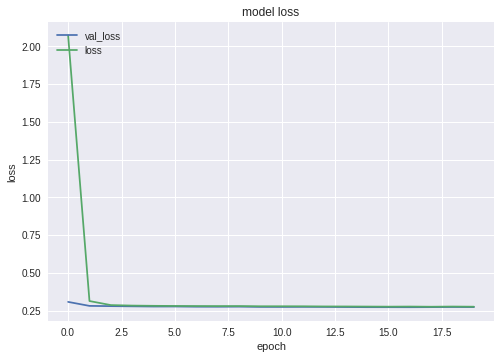

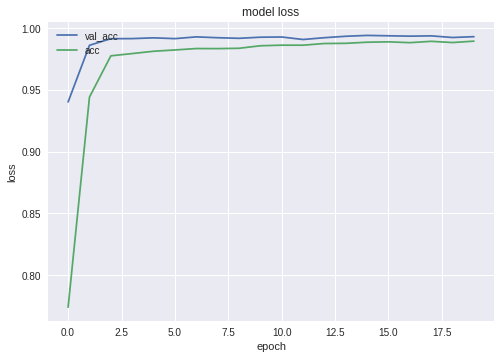

In [53]:
EPOCHS = 20
BATCH_SIZE = 275

early_stopping = EarlyStopping(monitor='val_loss', patience=5)


model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                       input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.3))

# model.add(layers.Dense(8, activation='relu'))
# model.add(layers.Dropout(0.3))

model.add(layers.Dense(y_train.shape[1],activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,verbose=1, validation_data=(X_test,y_test), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()

In [62]:
import json
text = '''[ {
  "tag" : null,
  "iid" : null,
  "style" : null,
  "text" : "",
  "href" : null,
  "label" : null,
  "x" : 0,
  "y" : 0,
  "height" : 0,
  "width" : 0,
  "value" : null,
  "location" : null,
  "size" : null,
  "image" : false,
  "selected" : false,
  "searchCriteria" : null,
  "selectedOption" : null,
  "selectedOptions" : null,
  "selectedValue" : null,
  "selectedText" : null,
  "wrappedDriver" : null,
  "displayed" : false,
  "rect" : null,
  "coordinates" : null,
  "wrappedElement" : null,
  "tagName" : null,
  "enabled" : false
} ]'''
sample = json.loads(text)
print(sample)
sample = pd.DataFrame(sample)
sample_df = prepare_data(sample)
print(sample_df)
print(sample_df.columns)

result = model.predict(sample_df)
print(result)
result = np.argmax(result)
print(result)

result = label_dic.get(result)
print(result)


[{'tag': None, 'iid': None, 'style': None, 'text': '', 'href': None, 'label': None, 'x': 0, 'y': 0, 'height': 0, 'width': 0, 'value': None, 'location': None, 'size': None, 'image': False, 'selected': False, 'searchCriteria': None, 'selectedOption': None, 'selectedOptions': None, 'selectedValue': None, 'selectedText': None, 'wrappedDriver': None, 'displayed': False, 'rect': None, 'coordinates': None, 'wrappedElement': None, 'tagName': None, 'enabled': False}]
row_df:  coordinates  displayed  enabled  height  href   iid  image label location  \
0        None      False    False       0  None  None  False  None     None   

   rect ... style   tag tagName text value width wrappedDriver wrappedElement  \
0  None ...  None  None    None       None     0          None           None   

   x  y  
0  0  0  

[1 rows x 27 columns]
filterd row_df:  coordinates  displayed  enabled  height  href   iid  image label location  \
0        None      False    False       0  None  None  False  None     

In [0]:

def prepare_data(data):
    text_df = pd.DataFrame(data)
    print("row_df:{}".format(text_df))
    text_df[["iid", "style", "text"]] = text_df[["iid", "style", "text"]].applymap(lambda x: wakati(x)).fillna("")
    text_df[["iid", "style"]] = text_df[["iid", "style"]].applymap(lambda x: add_space_front_uppercase(x))
    text_df[["iid", "style"]] = text_df[["iid", "style"]].applymap(lambda x: add_space_color_size(x))
    text_df["tag"] = text_df[["tag"]].applymap(lambda x: tag_filter(x))
    print("filterd row_df:{}".format(text_df))

    df = text_df
    fileds = ["x", "y", "height","width" ]
    X = df[fileds]

    df_tag = load_tokanaize(df, "tag")
    X = X.join(df_tag)

    df_iid = load_tokanaize(df, "iid")
    X = X.join(df_iid)

    df_style = load_tokanaize(df, "style")
    X = X.join(df_style)

    df_style = load_tokanaize(df, "text")
    X = X.join(df_style)
    X = X.fillna(0)

    return X

In [0]:
token_path = "{}/tokenizer_{}.pickle"

def load_tokanaize(df, filed, ):
    token = None
    # loading
    with open(token_path.format(base_dir,filed), 'rb') as handle:
        token = pickle.load(handle)

    text_matrix = token.texts_to_matrix(df[filed], mode='count')
    df_temp = pd.DataFrame(text_matrix)
    column_size = len(df_temp.columns)
    print(filed)
    print(df_temp)
    print(column_size)
    columns = ["{}{}".format(filed, i) for i in range(column_size)]
    df_temp.columns = columns
    return df_temp


モデルを保存


In [0]:

# serialize model to JSON
model_json = model.to_json()
with open("model_012.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_012.h5")
print("Saved model to disk")

Saved model to disk


モデルを読み込み

In [0]:

# load json and create model
json_file = open('model_012.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_012.h5")
print("Loaded model from disk")

Loaded model from disk


モデルを使って検証

In [0]:

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 99.32%


In [0]:
files.download("model_012.json")


In [0]:
files.download("model_012.h5")